# Time Series Analysis in Python

Time Series data is a set of observations on the values that a variable takes at different times. Such data may be collected at regular time intervals such as hourly,daily,weekly,monthly,quaterly,anually etc.      
The difference of time period between two observations would be equal throughout. i.e. t2-t1 = t3-t2

The dataset under study is a univariate time series data of passenger traffic count of a new transportation service. We need to forecast the passenger traffic for the next period using time series analysis.


### Importing necessary modules

In [1]:
import numpy as np                               
import pandas as pd                             
import matplotlib.pyplot as plt                  
import seaborn as sns                            
#plt.style.use('fivethirtyeight') 
from dateutil.relativedelta import relativedelta 

import warnings                                  
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Evaluation metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

#### Loading csv data into Pandas dataframe

In [3]:
df_train_raw = pd.read_csv('D:/AI Data Science/Dataset/Train_SU63ISt.csv')

In [4]:
df_test_raw = pd.read_csv('D:/AI Data Science/Dataset/Test_0qrQsBZ.csv')

In [5]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
ID          18288 non-null int64
Datetime    18288 non-null object
Count       18288 non-null int64
dtypes: int64(2), object(1)
memory usage: 428.7+ KB


We first convert the 'Datetime' column into pandas datetime datatype and we'll create new features such as year,month,day,hour,day of week and weekend/weekday flags using the below user defined functions.

In [6]:
def weekend_flag(row):
        if row.day_of_week==5 or row.day_of_week==6:
            return 1
        else:
            return 0
        
def data_prep(df):
    df.index = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M')
    df.Datetime = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M')

    df['year'] = df.Datetime.dt.year
    df['month'] = df.Datetime.dt.month
    df['day'] = df.Datetime.dt.day
    df['hour'] = df.Datetime.dt.hour

    df['day_of_week'] = df.Datetime.dt.dayofweek

    df['weekend'] = df.apply(weekend_flag,axis=1)

    df = df.drop(['Datetime','ID'],axis=1)
    
    return df

In [7]:
df_train_all = data_prep(df_train_raw)
df_test = data_prep(df_test_raw)

In [8]:
df_train_all.head()

,Count,year,month,day,hour,day_of_week,weekend
Datetime,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2,2012,8,25,4,5,1


In [9]:
print('Train data time period --- Start:',df_train_all.index.min().strftime('%D %H:%M:%S'))
print('Train data time period --- End:',df_train_all.index.max().strftime('%D %H:%M:%S'))   

Train data time period --- Start: 08/25/12 00:00:00
Train data time period --- End: 09/25/14 23:00:00


In [10]:
print('Test data time period --- Start:',df_test.index.min().strftime('%D %H:%M:%S'))
print('Test data time period --- End:',df_test.index.max().strftime('%D %H:%M:%S'))  

Test data time period --- Start: 09/26/14 00:00:00
Test data time period --- End: 04/26/15 23:00:00


As we can see the train data comprises of hourly level passenger count data from 25th August 2012 to 25th September 2014. Using this data we need to perform time series forecasting for the test data for 7 months from September 26th 2014 to 26th April 2015 using the last 25 month data.

Before moving into modelling the data we'll perform data exploration to find patterns and may be support our hypothesis of factors which could affect the outcome which in our case is passenger inflow.

### Exploratory Data Analysis

In [11]:
df = df_train_all.copy()

In [12]:
df_train = df

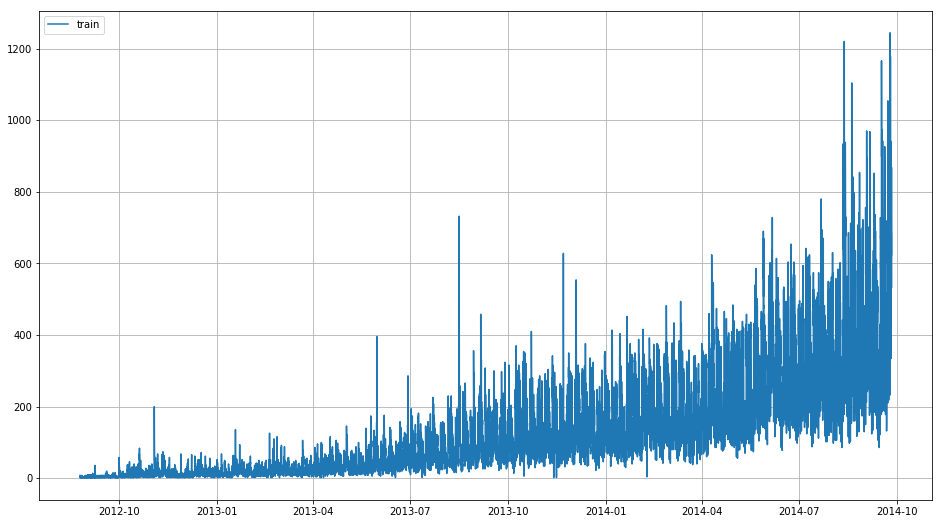

In [13]:
plt.figure(figsize=(16, 9))
plt.plot(df_train['Count'],label='train')
plt.grid(True)
plt.legend()

Due to hourly collected data we are seeing irregularities and  unable to see clear patterns in our data but we can infer here that our data has some increasing trend.In terms of seasonality and cyclic trend it is difficult to check in this plot.Therefore we will resample our data on daily,weekly,monthly and yearly level and visualize to understand the patterns.

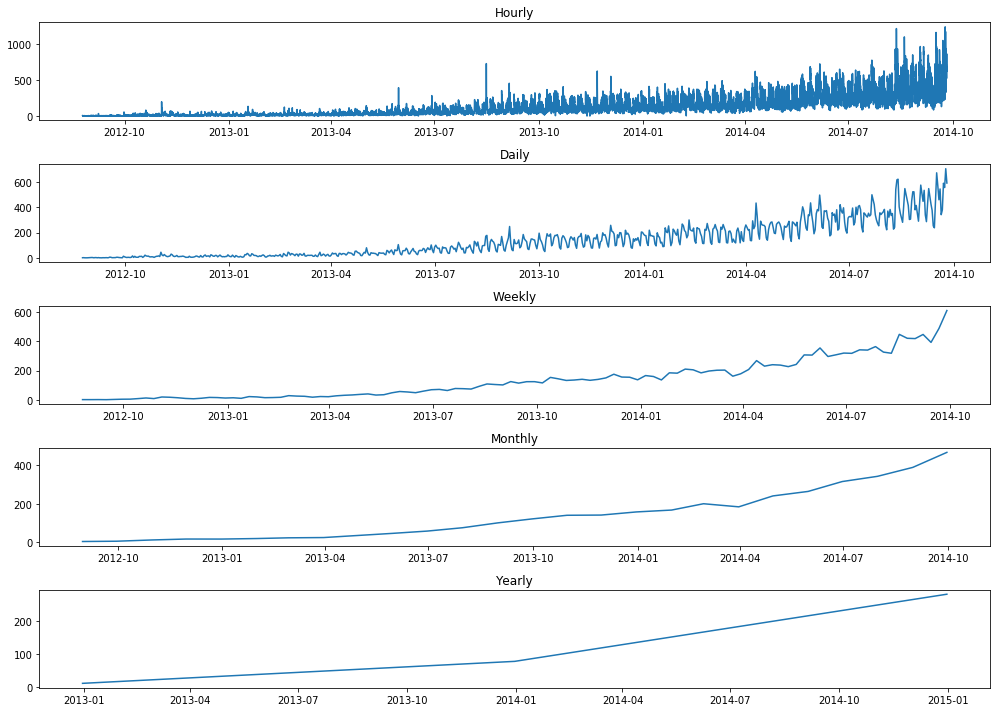

In [14]:
fig,ax = plt.subplots(5,1,figsize=(14,10))
axs = ax.flatten()
axs[0].plot(df_train['Count'])
axs[1].plot(df_train['Count'].resample('D'))
axs[2].plot(df_train['Count'].resample('W'))
axs[3].plot(df_train['Count'].resample('M'))
axs[4].plot(df_train['Count'].resample('Y'))
axs[0].set_title('Hourly')
axs[1].set_title('Daily')
axs[2].set_title('Weekly')
axs[3].set_title('Monthly')
axs[4].set_title('Yearly')
plt.tight_layout()
plt.show()

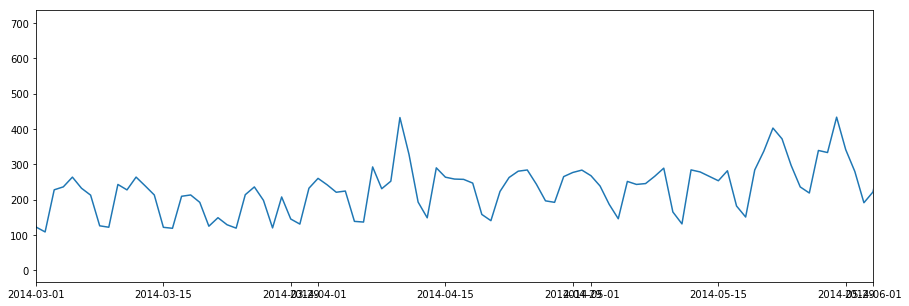

In [15]:
plt.figure(figsize=(15,5))
plt.plot(df_train['Count'].resample('D'))
plt.xlim('2014-03','2014-06')
plt.show()

On resampling at a daily level we can clearly see trend and seasonal patterns emerging from our data.We would use our daily resampled time series data for modelling as it has lesser noise compared to hourly data.

No we'll check our hypothesis on whether the weekend would have higher passenger count compared to weekdays and how other date related features affect the passenger count. We plot the aggregated data to check the passenger inflow varies depending on features such as day of week,hour of day,weekend/weekday and year levels.

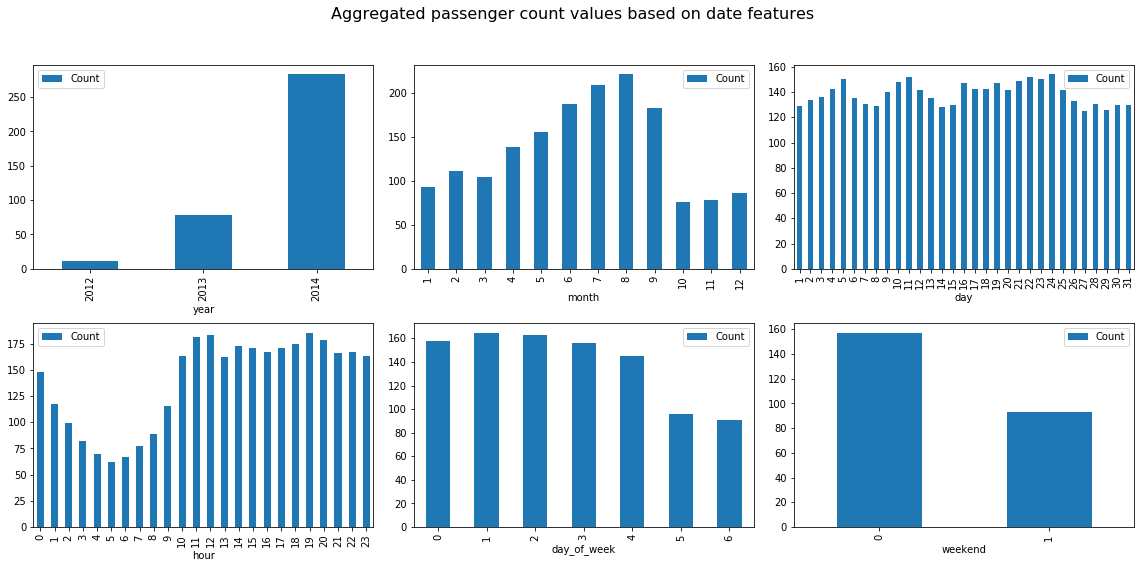

In [16]:
fig,ax = plt.subplots(2,3,figsize=(16, 8))
df_train.groupby(['year']).agg({'Count':np.mean}).plot(kind='bar',ax=ax[0][0])
df_train.groupby(['month']).agg({'Count':np.mean}).plot(kind='bar',ax=ax[0][1])
df_train.groupby(['day']).agg({'Count':np.mean}).plot(kind='bar',ax=ax[0][2])
df_train.groupby(['hour']).agg({'Count':np.mean}).plot(kind='bar',ax=ax[1][0])
df_train.groupby(['day_of_week']).agg({'Count':np.mean}).plot(kind='bar',ax=ax[1][1])
df_train.groupby(['weekend']).agg({'Count':np.mean}).plot(kind='bar',ax=ax[1][2])
fig.suptitle('Aggregated passenger count values based on date features',size=16)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

We can infer a lot of information from these plots on how the passenger inflow varies on different levels.
The passenger inflow has drastically increased on an average compared to previous two years and July/August months have higher passengers compared to other months due to holiday season in this area.On a hourly basis it is clear the passengers count increases from 9AM and coninues thoroughout the day only to gradually decrease after midnight. Suprisingly the passenger inflow in much higher on weekdays compared to weekend which can be attributed to working days and hence large proportion of people using this transportation for work commute.

##### Box plot to check the contribution % of hourly level and daily level granularity.

Here we calculate the contribution% of each hour compared to the whole day and simillarly calculate the contribution% of each day within each fiscal week,finally we plot these contributions using box plot to check if there are significant differences of each hours contribution or day of the week contribution.

In [17]:
df = df_train_all.copy()
def fiscal_day(row):
    return str(str(row.year)+str(row.month)+str(row.day))
df['fiscal_day'] = df.apply(fiscal_day,axis=1)
df['daily_sum_count'] = df.groupby(['fiscal_day'])['Count'].transform('sum')
df["hour_weight"] = df.Count / df.daily_sum_count
df["hour_weight"] *= 100

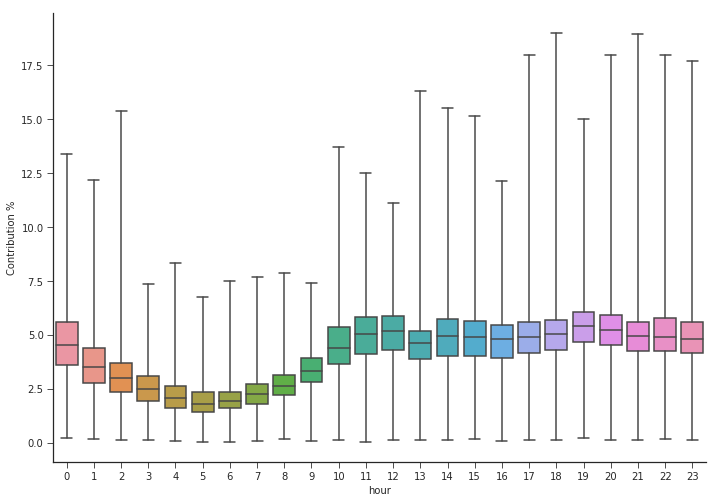

In [18]:
import seaborn as sns
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x='hour', y='hour_weight', data=df.sort_values(by=['hour_weight'],ascending=False)[1:],whis=np.inf)
#sns.violinplot(x='hour', y='hour_weight', data=df,whis=np.inf)
#sns.stripplot(x='hour', y='hour_weight', data=df, jitter=True, color=".3")
plt.ylabel("Contribution %")
sns.despine()
plt.show()

It is clear from this plot that the passenger counts decline from 12AM gradually till 5AM and later picks up from 7AM to 10AM after which the passenger inflow is considerably high through out till 11PM.

In [19]:
df = df_train_all.copy()
df = df.resample('D').mean()
df['week_no'] = df.index.weekofyear
df['week_no'] = df['week_no'].apply(lambda x:str(x).split('.')[0])
df['year'] = df['year'].apply(lambda x: str(x).split('.')[0])#(df_day.groupby("week")["consumption"].transform(sum))
def fiscal_week(row):
    return str(str(row.year)+str(row.week_no))
df['fiscal_week_id'] = df.apply(fiscal_week,axis=1)
df['weekly_sum_count'] = df.groupby(['fiscal_week_id'])['Count'].transform('sum')
df["week_weight"] = df.Count / df.weekly_sum_count
df["week_weight"] *= 100
df["day_name"] = df.index.map(lambda x: x.strftime("%A"))

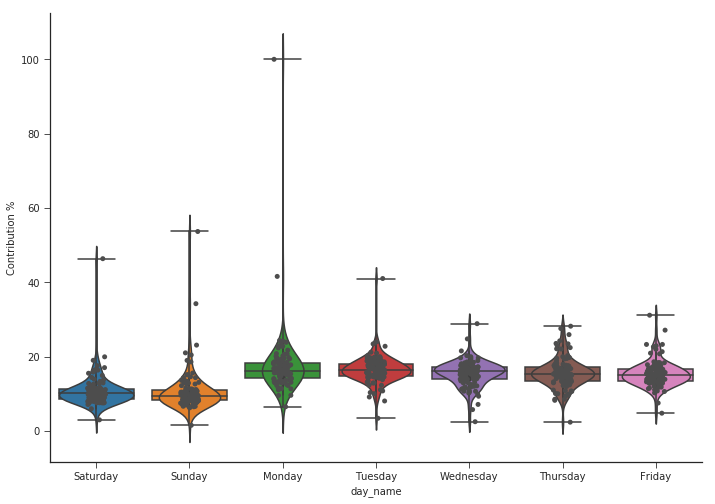

In [20]:
import seaborn as sns
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x='day_name', y='week_weight', data=df,whis=np.inf)
sns.violinplot(x='day_name', y='week_weight', data=df,whis=np.inf)
sns.stripplot(x='day_name', y='week_weight', data=df, jitter=True, color=".3")
plt.ylabel("Contribution %")
sns.despine()
plt.show()

We can clearly infer more passenger counts during weekdays compared to weekends as we had seen earlier.1

####

In [21]:
df_train = df_train.resample('D').mean()
df_test = df_test.resample('D').mean()
### SPLITING DATA INTO TRAINING AND VALIDATION PART
Train=df_train.ix['2012-08-25':'2014-06-24']
valid=df_train.ix['2014-06-25':'2014-09-25']


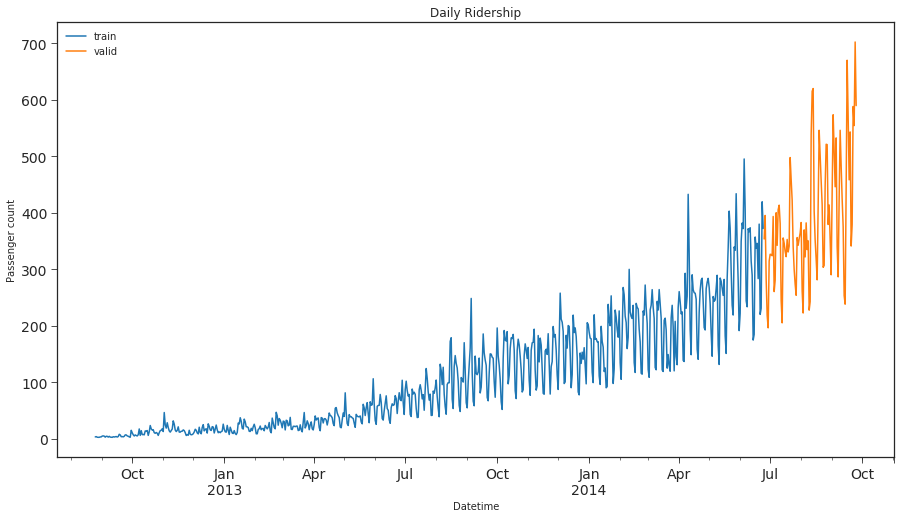

In [22]:
### Now we will look at how the train and validation part has been divided.
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#### Data stationarity
A time series Y_t (t=1,2...) is said to be stationary (in the weak sense) if its statistical properties do not vary with time (expectation, variance, autocorrelation). The white noise is an example of a stationary time series, with for example the case where Y_t follows a normal distribution N(mu, sigma^2) independent of t.

Identifying that a series is not stationary allows to afterwards study where the non-stationarity comes from. A non-stationary series can, for example, be stationary in difference (also called integrated of order 1): Y_t is not stationary, but the Y_t  - Y_{t-1}  difference is stationary. It is the case of the random walk. A series can also be stationary in trend.

Stationarity tests allow verifying whether a series is stationary or not. There are two different approaches: stationarity tests such as the KPSS test that consider as null hypothesis H0 that the series is stationary, and unit root tests, such as the Dickey-Fuller test and its augmented version, the augmented Dickey-Fuller test (ADF), or the 

Weak stationarity means that the first and second moments (so the mean, variance, and autocovariance) don't change with time. A strongly stationary process has the same distribution no matter the time, but let's focus on the weakly stationary process, as any strongly stationary process is weakly stationary.

Because when estimating the mean and variance of your data, non stationarity will bias those estimates. Forecasting will be much worse, and the estimates of correlation and covariance will be unreliable.

Moving averages should be calculated when the mean is as fixed as possible.

 Stationarity is defined uniquely, i.e. data is either stationary or not, so there is only way for data to be stationary, but lots of ways for it to be non-stationary. Again it turns out that a lot of data becomes stationary after certain transformation. ARIMA model is one model for non-stationarity. It assumes that the data becomes stationary after differencing.

###### Autocorrelation and Partial Autocorrelation

• The autocorrelation function (ACF) plot shows the
correlation of the series with itself at different lags    
– The autocorrelation of Y at lag k is the correlation between
Y and LAG(Y,k)

• The partial autocorrelation function (PACF) plot
shows the amount of autocorrelation at lag k that is
not explained by lower-order autocorrelations    
– The partial autocorrelation at lag k is the coefficient of
LAG(Y,k) in an AR(k) model, i.e., in a regression of Y on
LAG(Y, 1), LAG(Y,2), … up to LAG(Y,k)

• ACF that dies out gradually and PACF that cuts off
sharply after a few lags  AR signature     
– An AR series is usually positively autocorrelated at lag 1
(or even borderline nonstationary)

• ACF that cuts off sharply after a few lags and PACF
that dies out more gradually  MA signature      
– An MA series is usually negatively autcorrelated at lag 1
(or even mildly overdifferenced)

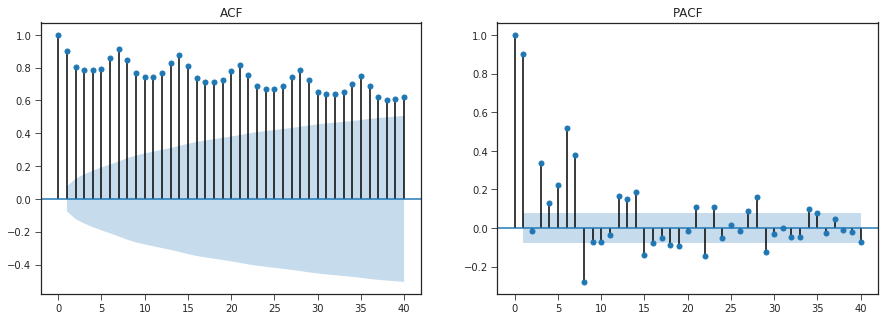

In [24]:
#from statsmodels.tsa.stattools import acf,pacf
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = Train['Count']
#acf = acf(data, nlags=40)
#pacf = pacf(data,nlags=40,method='ols')

#plt.stem(acf)
fig,ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(data,lags=40,title="ACF",ax=ax[0])
#plt.show()
plot_pacf(data,lags=40,title="PACF",ax=ax[1])
plt.show()


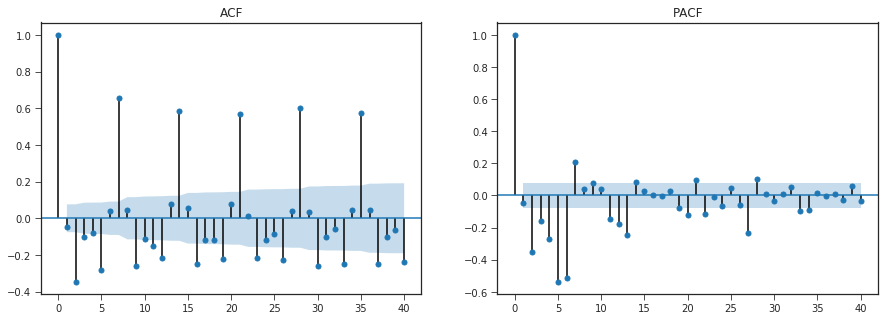

In [25]:
data1 = data.diff(periods=1).values[1:]
fig,ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(data1,lags=40,title="ACF",ax=ax[0])
#plt.show()
plot_pacf(data1,lags=40,title="PACF",ax=ax[1])
plt.show()

ACF - As all lags are close to 1 or atleast greater than confidence interval ,autocorrelation is statisitically significant.

PACF - 

#### 1. NAIVE APPROACH
In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction:


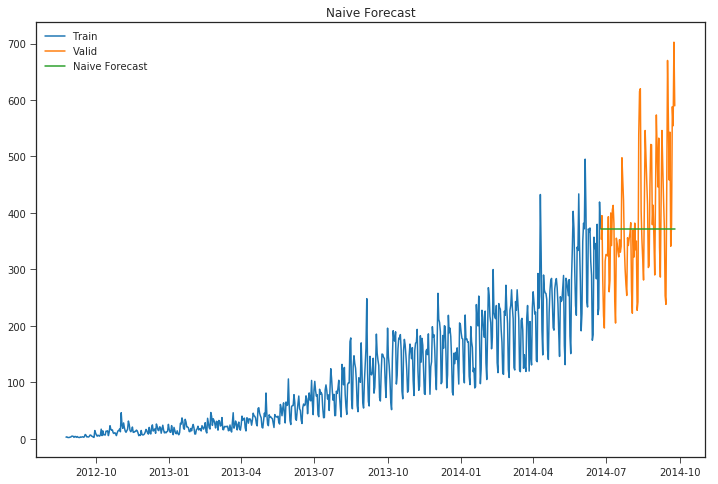

r2_score >>> -0.02404216991538255
mean_absolute_percentage_error >>> 22.91834464294656
median_absolute_error >>> 65.5
mean_absolute_error >>> 86.68458781362007
mean_squared_error >>> 12497.116935483871
mean_squared_log_error >>> 0.07875605388878908


In [26]:
trn_cnt= np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = trn_cnt[len(trn_cnt)-1]
plt.figure(figsize=(12,8))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index,valid['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

print("r2_score >>>",r2_score(y_hat['Count'], y_hat['naive']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat['Count'], y_hat['naive']))
print("median_absolute_error >>>",median_absolute_error(y_hat['Count'], y_hat['naive']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat['Count'], y_hat['naive']))
print("mean_squared_error >>>",mean_squared_error(y_hat['Count'], y_hat['naive']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat['Count'], y_hat['naive']))

#### Simple Average

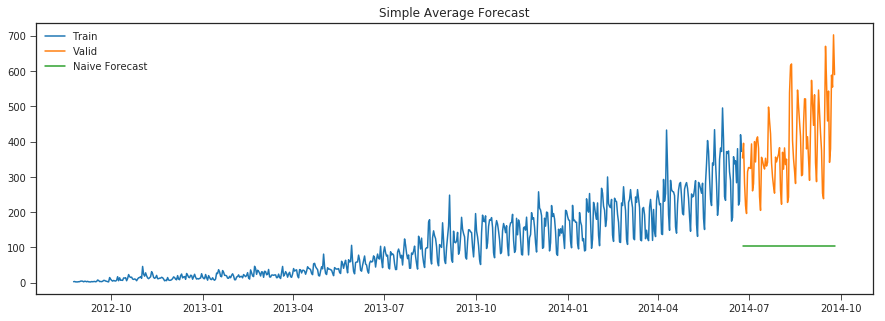

r2_score >>> -6.662202498647111
mean_absolute_percentage_error >>> 71.04725322248096
median_absolute_error >>> 260.00884404583957
mean_absolute_error >>> 285.1378763039041
mean_squared_error >>> 93507.32169248654
mean_squared_log_error >>> 1.6971961068304557


In [27]:
trn_cnt= np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['avg'] = trn_cnt.mean()
plt.figure(figsize=(15,5))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index,valid['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['avg'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.show()

print("r2_score >>>",r2_score(y_hat['Count'], y_hat['avg']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat['Count'], y_hat['avg']))
print("median_absolute_error >>>",median_absolute_error(y_hat['Count'], y_hat['avg']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat['Count'], y_hat['avg']))
print("mean_squared_error >>>",mean_squared_error(y_hat['Count'], y_hat['avg']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat['Count'], y_hat['avg']))

### Moving Average

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like y^t=yt−1y^t=yt−1 (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its kk previous values. Therefore, we will use the moving average.

y^t=yt−1



In [28]:
#rolling_mean = Train['count'].rolling(2).mean()
def moving_average_predict_plot(window):
    rolling_mean_train = Train['Count'].rolling(window).mean()
    rolling_mean_valid = valid['Count'].rolling(window).mean()
    plt.figure(figsize=(15, 5))
    plt.plot(df['Count'],label='original')
    plt.plot(Train['Count'],label='train')
    plt.plot(rolling_mean_train,label='train_rolling_mean_{}'.format(str(window)))
    #mea = mean_absolute_error(Train['count'][2:],rolling_mean[2:])
    #sd = np.std(df['count'][2:] - rolling_mean[2:])
    #cf_up = rolling_mean + (mea + (1.96*sd))
    #cf_low = rolling_mean - (mea+(1.96*sd))
    #plt.plot(cf_up,'r--')
    #plt.plot(cf_low,'r--')
    #mea = mean_absolute_error(valid['Count'][window:],rolling_mean_valid[window:])
    #sd = np.std(valid['Count'][window:] - rolling_mean_valid[window:])
    #cf_up = rolling_mean + (mea + (1.96*sd))
    #cf_low = rolling_mean - (mea+(1.96*sd))
    #plt.plot(cf_up,'r--')
    #plt.plot(cf_low,'r--')
    plt.plot(rolling_mean_valid,label='valid_rolling_mean_{}'.format(str(window)))
    plt.title('Moving average - window:{}'.format(str(window)))
    plt.grid(True)
    plt.legend()
    plt.show()
    print( 'RMSE:',np.sqrt(mean_squared_error(valid['Count'][window:],rolling_mean_valid[window:])))

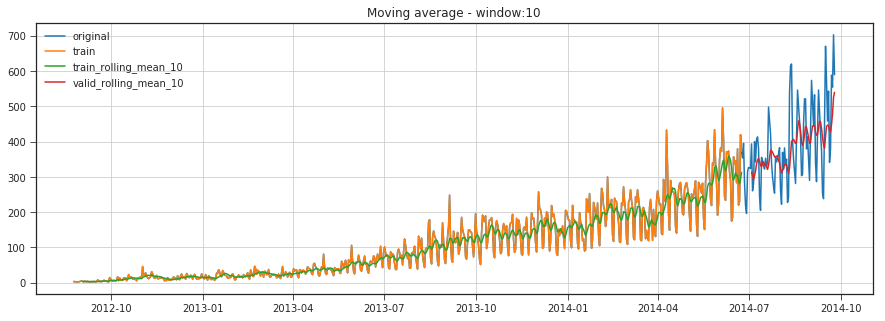

RMSE: 90.9914913199977


In [29]:
moving_average_predict_plot(10)

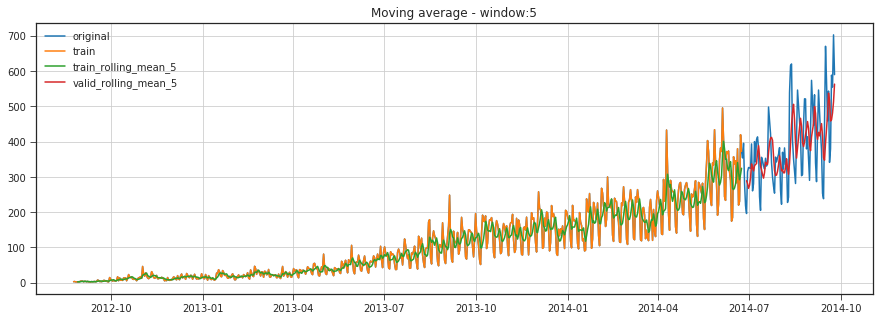

RMSE: 94.86415250533551


In [30]:
moving_average_predict_plot(5)

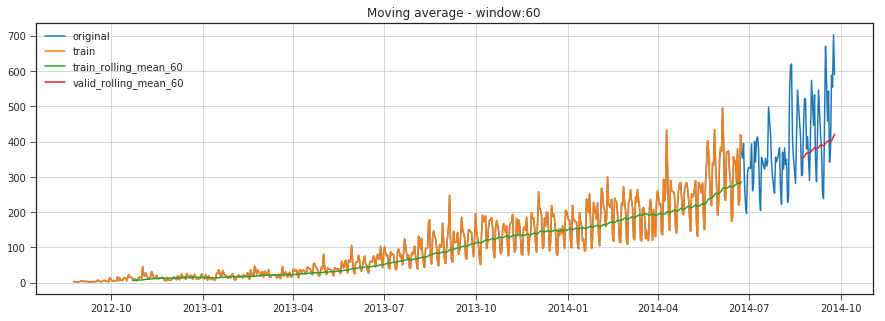

RMSE: 129.40415262528867


In [31]:
moving_average_predict_plot(60)

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In real-world scenarios our prediction would be as below as we would not know in prior the previous value observed.

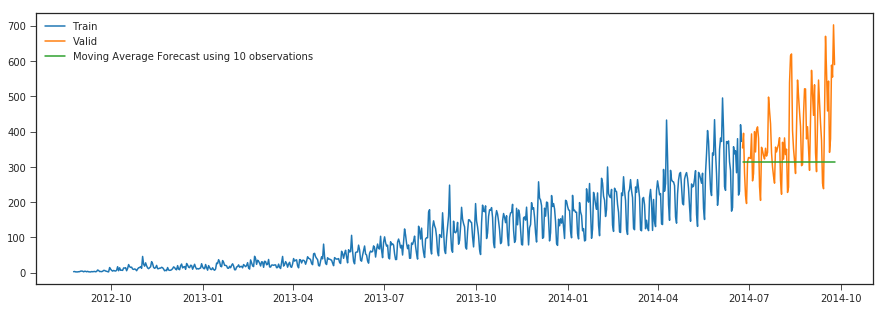

r2_score >>> -0.4765720330640295
mean_absolute_percentage_error >>> 23.402587178079358
median_absolute_error >>> 69.7166666666667
mean_absolute_error >>> 100.90824372759855
mean_squared_error >>> 18019.66159498208
mean_squared_log_error >>> 0.11046352508245877


In [32]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations.
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()
print("r2_score >>>",r2_score(y_hat_avg['Count'], y_hat_avg['moving_avg_forecast']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat_avg['Count'], y_hat_avg['moving_avg_forecast']))
print("median_absolute_error >>>",median_absolute_error(y_hat_avg['Count'], y_hat_avg['moving_avg_forecast']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat_avg['Count'], y_hat_avg['moving_avg_forecast']))
print("mean_squared_error >>>",mean_squared_error(y_hat_avg['Count'], y_hat_avg['moving_avg_forecast']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat_avg['Count'], y_hat_avg['moving_avg_forecast']))

#### Simple Exponential Smoothing
predictions are made by assigning larger weight to the recent values and lesser weight to the old values. When applied to time series forecasting the basic idea is to look at previous measurements and weight them according to how distant in the past they are, typically this decays exponentially the farther back in time you go so that older observations have less influence on the forecast

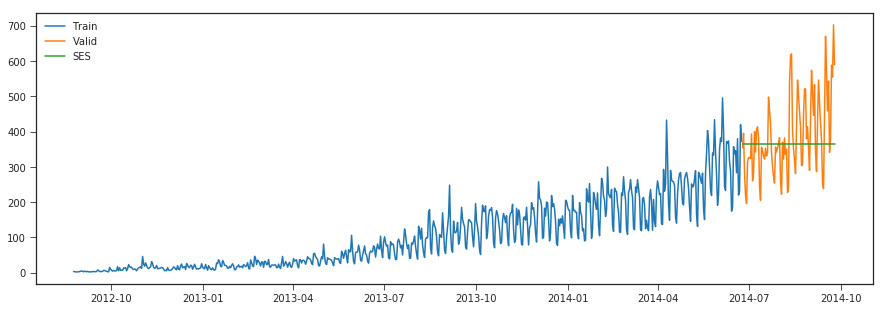

r2_score >>> -0.05443082552571954
mean_absolute_percentage_error >>> 22.35065218235077
median_absolute_error >>> 62.477507770932334
mean_absolute_error >>> 86.55172947423941
mean_squared_error >>> 12867.971372763452
mean_squared_log_error >>> 0.07956918735902696


In [33]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()
print("r2_score >>>",r2_score(y_hat_avg['Count'], y_hat_avg['SES']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat_avg['Count'], y_hat_avg['SES']))
print("median_absolute_error >>>",median_absolute_error(y_hat_avg['Count'], y_hat_avg['SES']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat_avg['Count'], y_hat_avg['SES']))
print("mean_squared_error >>>",mean_squared_error(y_hat_avg['Count'], y_hat_avg['SES']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat_avg['Count'], y_hat_avg['SES']))

#### Holt’s Linear Trend method

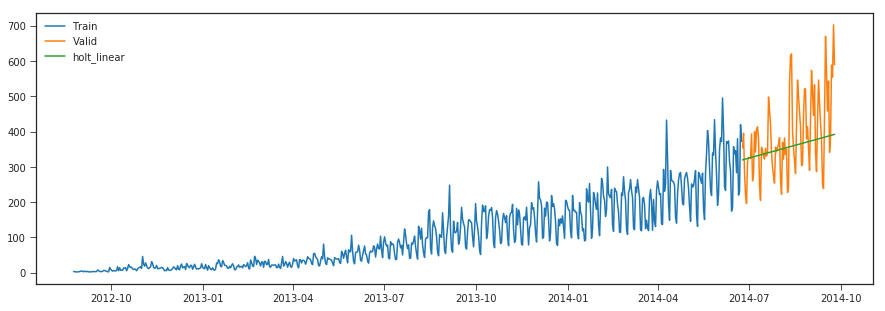

r2_score >>> 0.06943531380186796
mean_absolute_percentage_error >>> 20.325129883009378
median_absolute_error >>> 66.43587545533114
mean_absolute_error >>> 80.37510479716255
mean_squared_error >>> 11356.34453453304
mean_squared_log_error >>> 0.06855802909033636


In [34]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.2,smoothing_slope = 0.1)
y_hat_avg['holt_linear'] = fit2.forecast(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['holt_linear'], label='holt_linear')
plt.legend(loc='best')
plt.show()

print("r2_score >>>",r2_score(y_hat_avg['Count'], y_hat_avg['holt_linear']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat_avg['Count'], y_hat_avg['holt_linear']))
print("median_absolute_error >>>",median_absolute_error(y_hat_avg['Count'], y_hat_avg['holt_linear']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat_avg['Count'], y_hat_avg['holt_linear']))
print("mean_squared_error >>>",mean_squared_error(y_hat_avg['Count'], y_hat_avg['holt_linear']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat_avg['Count'], y_hat_avg['holt_linear']))

This method only captures the linear trend in our data for forecasting wherease it misses out on capturing the multiplicative seasonal pattern.

 ####  Holt-Winters Method

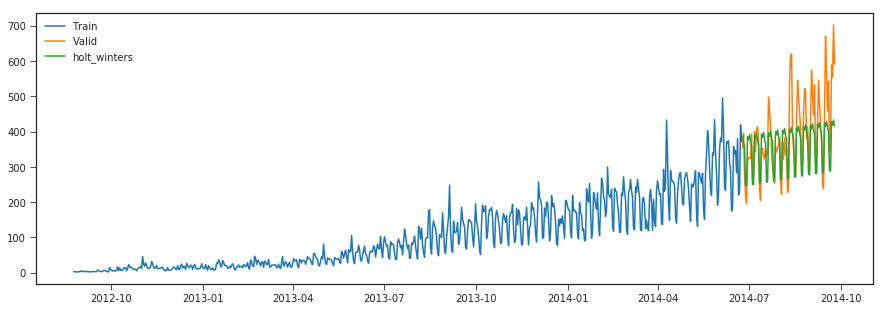

r2_score >>> 0.4439655242397562
mean_absolute_percentage_error >>> 14.298419970700103
median_absolute_error >>> 43.27903481717709
mean_absolute_error >>> 60.57966738353202
mean_squared_error >>> 6785.68526558865
mean_squared_log_error >>> 0.034678526680439636


In [35]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = ExponentialSmoothing(np.asarray(Train['Count']),seasonal_periods=7 ,trend='add', seasonal='add').fit()
y_hat_avg['holt_winters'] = fit2.forecast(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['holt_winters'], label='holt_winters')
plt.legend(loc='best')
plt.show()

print("r2_score >>>",r2_score(y_hat_avg['Count'], y_hat_avg['holt_winters']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat_avg['Count'], y_hat_avg['holt_winters']))
print("median_absolute_error >>>",median_absolute_error(y_hat_avg['Count'], y_hat_avg['holt_winters']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat_avg['Count'], y_hat_avg['holt_winters']))
print("mean_squared_error >>>",mean_squared_error(y_hat_avg['Count'], y_hat_avg['holt_winters']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat_avg['Count'], y_hat_avg['holt_winters']))

The above methods doesn't seem to capture the overall multiplicative seasonality and trend patterns in the data,on looking at the plot of the timeseries data we can see there is positive linear trend , multiplicative seasonal patterns and few irregular patterns,therefore we could use SARIMA model for our forecasting.

#### Time Series Decomposition.

Some distinguishable patterns appear when we plot the data. The time-series has an obvious multiplicative seasonality pattern, as well as an overall increasing trend. We can also visualize our data using a method called time-series decomposition. As its name suggests, time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

Trend: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend “changing direction” when it might go from an increasing trend to a decreasing trend.

Seasonal: A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality always has a fixed and known period.

Cycles: A cyclic pattern exists when data exhibit rises and falls that are not from the fixed period. The duration of these fluctuations is usually of at least 2 years.

Noise: The random variation in the series.

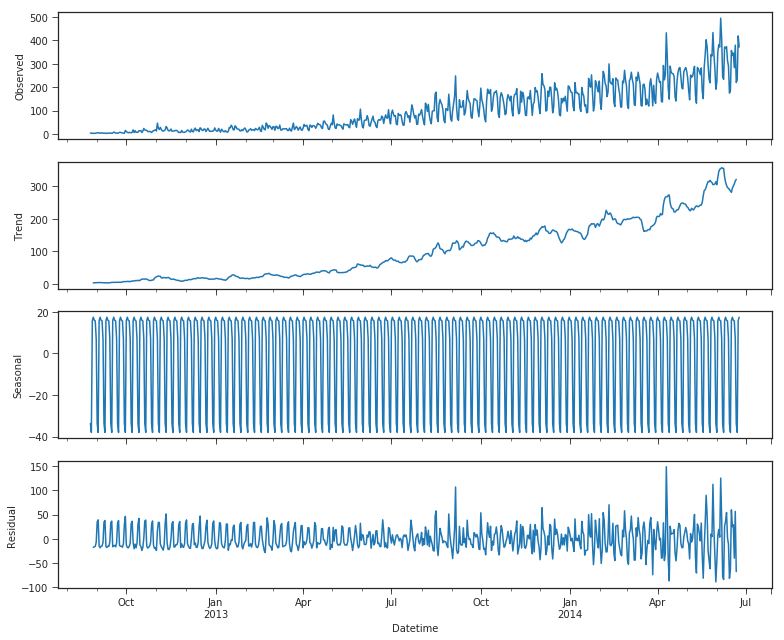

In [36]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
import matplotlib.pyplot as plt 
model=sm.tsa.seasonal_decompose(Train['Count'],model='additive')
fig = model.plot()
plt.show()
#fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
#model.trend.plot(ax=ax1)
#model.seasonal.plot(ax=ax2)
#model.resid.plot(ax=ax3)

Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plot above clearly shows the upwards trend of our data, along with its seasonality. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.

Next since the data has multiplicative seasonality we apply a log filter and then analyze the residuals with autocorrelation plots.

In [37]:
data = Train['Count']
data = np.log(data)

In [38]:
data_diff = data.diff(periods=1).values[1:]

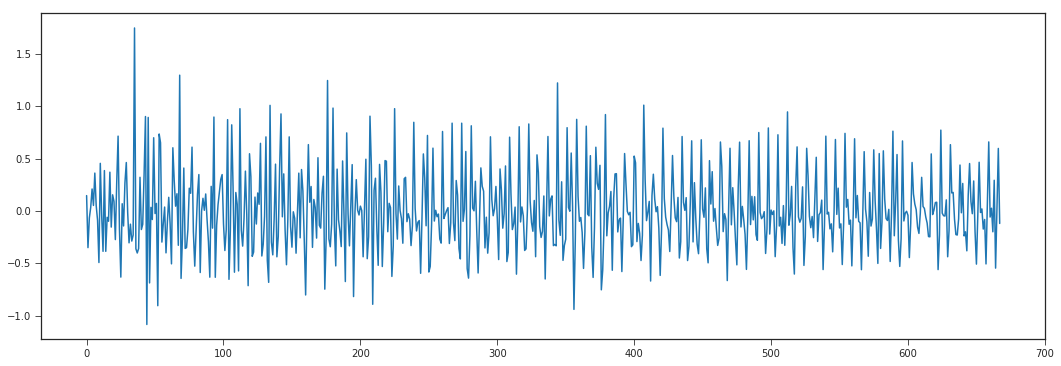

In [39]:
plt.plot(data_diff)
plt.gcf().set_size_inches(18,6)

##### Checking data stationarity 

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.   
Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables

In [40]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_train.Count, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   2.986351
p-value                          1.000000
#lags Used                      20.000000
Number of Observations Used    741.000000
Critical Value (1%)             -3.439206
Critical Value (5%)             -2.865448
Critical Value (10%)            -2.568851
dtype: float64


It is very clear from the p-value that this is not stationary and has varying statistical properties over time

#### ARIMA & SARIMA
One of the most communal modes used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to good understand or predict future points in the series.

There are three different numbers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and sound in datasets:

> p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be akin to stating that it is likely to be warm tomorrow if it has been warm the past 3 times. 

>d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the actual ideal) to enlistly to the time series. Intuitively, this would be akin to stating that it is likely to be same temperature tomorrow if the disagreement in temperature in the last three times has been very tiny.    

>q is the moving normal part of the model. This allows us to set the error of our model as a bilinear combination of the error values observed at preceding time points in the past.
When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are enlisted to the seasonal element of the time series. The statement s is the regularity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA mode can be discouraging because of the aggregate tuning parameters involved. In the next portion, we will describe how to automate the processes of identifying the best set of parameters for the seasonal ARIMA time series model.

ARIMA stands for AutoregRessive Integrated Moving Average, and it's a common method to model time series data where there is dependence among temporal values. SARIMA is a similar method that adds seasonality element to ARIMA. As shown below, user needs to specify some parameters to fit an ARIMA model within the Python statsmodel package (version 0.8).    
The ARIMA parameters are (p,d,q):     
p - the auto-regression term that comprises p number of past values to predict present value. For example, if p=2, then past values y(t-1), y(t-2) would be used to predict y(t).      
d - the integrated part of the model. Generally d=1, corresponding to the difference between current value and previous one. If d >1, it means the differencing would be performed more than once (i.e., difference of prior d number of values and present value).      
q - the Moving Average terms, which is used to generate the error terms of the model. This results in a linear combination of errors for the prior q data point, where each error is defined as the difference between the moving average value and the actual value at a given time point (t).
For SARIMA model, there's also (P,D,Q,S) parameters specified along with the (p,d,q). The P,D,Q values are similar to the parameters described above but it's applied to the seasonality componenet of the SARIMA model. S is the periodicity of the time series (4 for quarterly, 12 for yearly).

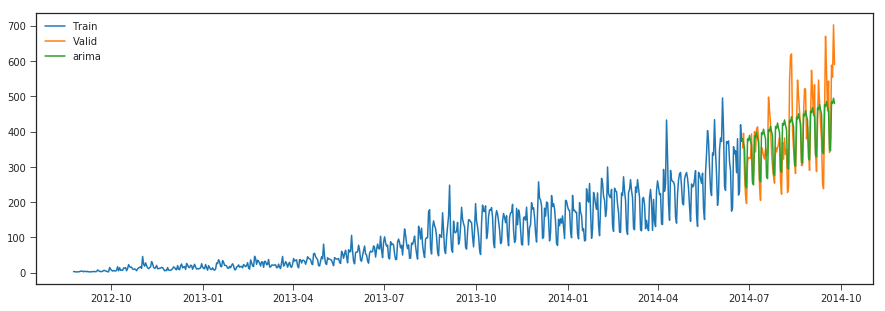

r2_score >>> 0.6179264938889601
mean_absolute_percentage_error >>> 13.832316408898384
median_absolute_error >>> 47.59288040566122
mean_absolute_error >>> 53.928107198396624
mean_squared_error >>> 4662.715485842272
mean_squared_log_error >>> 0.026348300266155537


In [41]:
import statsmodels.api as sm
y_hat_avg = valid.copy()
fit2 = sm.tsa.statespace.SARIMAX(np.asarray(Train['Count']),order=(2, 1, 2),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['arima'] = fit2.forecast(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['arima'], label='arima')

test_yhat = df_test.copy()
test_yhat['test_arima'] = fit2.forecast(len(df_test))
#plt.plot(df_test['Count'], label='test')
#plt.plot(test_yhat['test_arima'], label='testarima')
plt.legend(loc='best')
plt.show()

print("r2_score >>>",r2_score(y_hat_avg['Count'], y_hat_avg['arima']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat_avg['Count'], y_hat_avg['arima']))
print("median_absolute_error >>>",median_absolute_error(y_hat_avg['Count'], y_hat_avg['arima']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat_avg['Count'], y_hat_avg['arima']))
print("mean_squared_error >>>",mean_squared_error(y_hat_avg['Count'], y_hat_avg['arima']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat_avg['Count'], y_hat_avg['arima']))

The SARIMA model tends to capture both trend and seasonality better compared to other methods and is evident with the error metrics.Although we used the ACF and PACF plots to select the p,d,q parameters we would be better of with automatic selection of parameter through Auto ARIMA which selects the model by performing grid search of the paramters based on constraints provided and selects the best model with lowest AIC score.

In [47]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(Train['Count'], trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,d=1,max_d=3,
                  max_p=3, max_q=3, max_P=2, max_Q=2, seasonal=True,
                  stepwise=False, suppress_warnings=True, D=1, max_D=2,m=7,
                  error_action='ignore',approximation = False)
                        


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=6511.215, BIC=6520.202, Fit time=0.042 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=6214.605, BIC=6228.086, Fit time=0.266 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 7); AIC=6213.677, BIC=6231.652, Fit time=0.853 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=6390.441, BIC=6403.922, Fit time=0.304 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=6214.193, BIC=6232.168, Fit time=0.451 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 7); AIC=6215.042, BIC=6237.510, Fit time=1.700 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=6333.753, BIC=6351.728, Fit time=0.686 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=6210.945, BIC=6233.414, Fit time=1.293 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 2, 7); AIC=6198.921, BIC=6225.883, Fit time=3.608 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_o

Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 2, 7); AIC=6101.823, BIC=6133.279, Fit time=2.709 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=6206.316, BIC=6233.278, Fit time=1.076 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=6101.218, BIC=6132.674, Fit time=1.908 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 2, 7); AIC=6101.586, BIC=6137.536, Fit time=2.528 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=6304.855, BIC=6327.324, Fit time=0.636 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6030.463, BIC=6057.426, Fit time=1.649 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=6028.717, BIC=6060.174, Fit time=3.513 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=6180.848, BIC=6207.811, Fit time=2.282 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=6029.100, BIC=6060.556, Fit time=2.566 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_o

In [48]:
print(stepwise_model.aic())

6020.086526482221


In [49]:
stepwise_model.fit(Train['Count'])

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

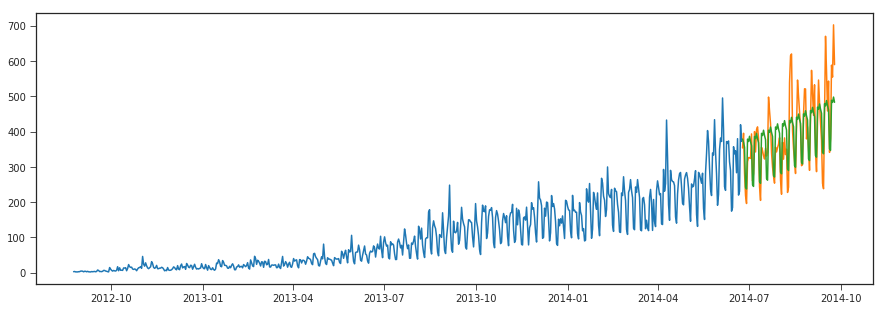

In [50]:
y_hat_avg1 = valid.copy()
y_hat_avg1['auto_arima'] = stepwise_model.predict(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg1['auto_arima'], label='auto_arima')

In [51]:
print("r2_score >>>",r2_score(y_hat_avg1['Count'], y_hat_avg1['auto_arima']))
print("mean_absolute_percentage_error >>>",mean_absolute_percentage_error(y_hat_avg1['Count'], y_hat_avg1['auto_arima']))
print("median_absolute_error >>>",median_absolute_error(y_hat_avg1['Count'], y_hat_avg1['auto_arima']))
print("mean_absolute_error >>>",mean_absolute_error(y_hat_avg1['Count'], y_hat_avg1['auto_arima']))
print("mean_squared_error >>>",mean_squared_error(y_hat_avg1['Count'], y_hat_avg1['auto_arima']))
print("mean_squared_log_error >>>",mean_squared_log_error(y_hat_avg1['Count'], y_hat_avg1['auto_arima']))

r2_score >>> 0.6251531643444177
mean_absolute_percentage_error >>> 13.58484603152323
median_absolute_error >>> 45.41053596424729
mean_absolute_error >>> 53.25297097623328
mean_squared_error >>> 4574.523272289658
mean_squared_log_error >>> 0.025711313858484044


The auto arima method tends to improve a little from our previous methods by automatic selection of paramters.